(3855.57, -10428.69)


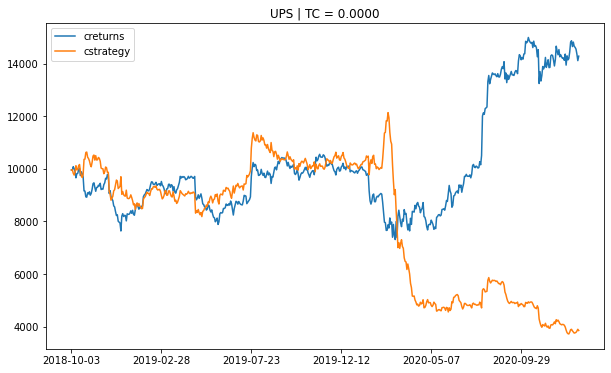

In [9]:
# Imports
import os, requests, json, dateutil.parser, time
import numpy as np
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv

# Load .env & variables
load_dotenv(verbose=True)
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

class MomBacktester(object):

    '''
    Class for the vectorized backtesting of
    Momentum-based trading strategies.

    Attributes
    ==========
    symbol: str
        financial instrument to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g. 0.1% = 0.001) per trade

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the momentum-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc):
        
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        
        '''
        Retrieves and prepares the data.
        '''
        
        # Alpaca Variables
        url = f"https://data.alpaca.markets/v1/bars/1D?symbols={self.symbol}&limit=1000&start={self.start}&end={self.end}"
        header = {
            "APCA-API-KEY-ID": alpaca_api_key,
            "APCA-API-SECRET-KEY": alpaca_secret_key
        }

        # Data Acquisition -> JSON formatting -> Dictionary
        req = requests.get(url, headers=header)
        info = json.loads(json.dumps(req.json(), indent=4))[self.symbol]

        # Empty Lists to Hold Info
        dates = []
        close = []
        
        # Parse through Data, Append to Lists
        for day in info:
            day['t'] = datetime.fromtimestamp(day['t']).strftime('%Y-%m-%d')
            dates.append(day['t'])
            close.append(day['c'])
        
        # Create DataFrames
        raw = pd.DataFrame(data={self.symbol:close}, index=dates)
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw

    def run_strategy(self, momentum=1):
        
        '''
        Backtests the trading strategy.
        '''
        
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['return'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['return']
        # determine when a trade takes place
        data.dropna(inplace=True)
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * \
            data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        
        '''
        Plots the performance of the trading strategy
        compared to the symbol.
        '''
        
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    
    # BackTest a security w/o TC
    ups = MomBacktester('UPS', '2018-1-1', '2020-12-31',
                                10000, 0.0)
    
    # Print & Plot results for range of momentums
    print(ups.run_strategy(momentum=1))
    ups.plot_results()

(9094.24, -5248.48)


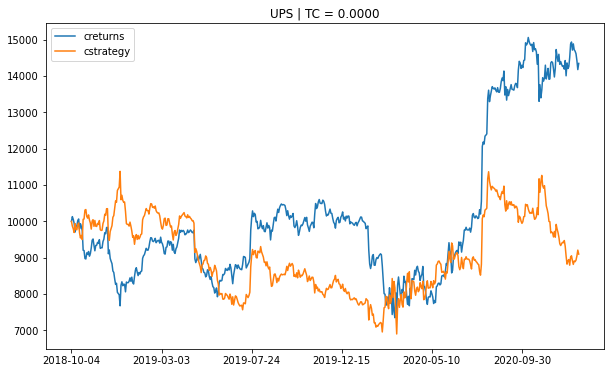

In [10]:
print(ups.run_strategy(momentum=2))
ups.plot_results()

(6029.15, -8322.13)


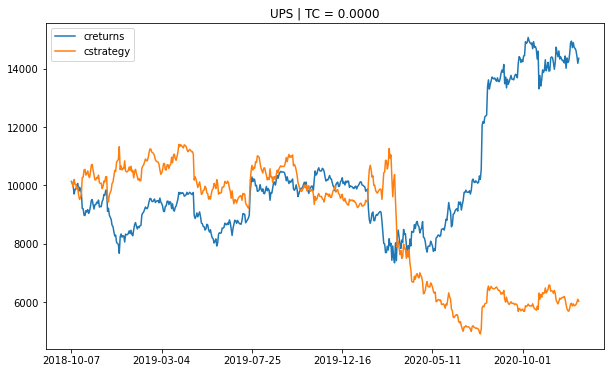

In [11]:
print(ups.run_strategy(momentum=3))
ups.plot_results()

(7155.52, -7009.67)


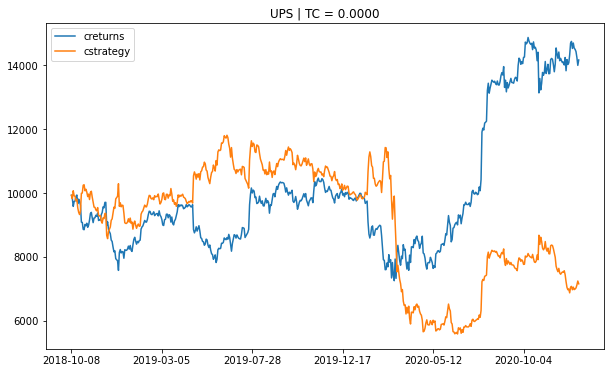

In [12]:
print(ups.run_strategy(momentum=4))
ups.plot_results()

(5517.76, -8750.75)


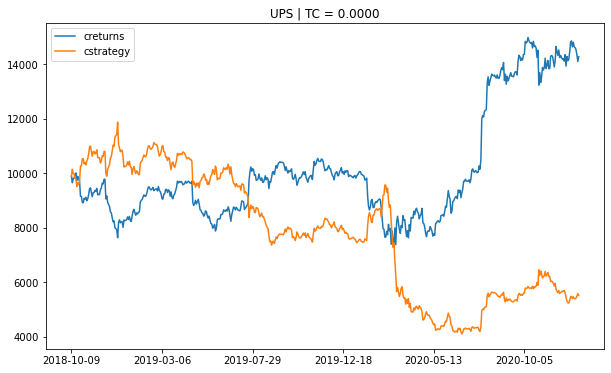

In [13]:
print(ups.run_strategy(momentum=5))
ups.plot_results()